# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

def get_page_content(url):
    response = requests.get(url)
    return BeautifulSoup(response.content, 'html.parser')

def extract_reviews(parsed_content):
    reviews = []
    for review in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(review.get_text())
    return reviews

def extract_ratings(parsed_content):
    ratings_list = []
    for stats in parsed_content.find_all("div", {"class": "review-stats"}):
        ratings = []
        for value in stats.find_all('td', {'class': 'review-value'}):
            ratings.append(value.get_text())

        recommend = ratings.pop()  # Assume last rating is "recommended"
        for stars in stats.find_all('td', {'class': 'review-rating-stars stars'}):
            rating = len(stars.find_all('span', {'class': 'star fill'}))
            ratings.append(rating)
        ratings.append(recommend)

        categories = [header.get_text() for header in stats.find_all('td', {'class': 'review-rating-header'})]
        ratings_list.append((categories, ratings))
    return ratings_list

def create_dataframe(reviews, ratings_list):
    df = pd.DataFrame()
    for categories, ratings in ratings_list:
        data_dict = pd.DataFrame([ratings], columns=categories)
        df = pd.concat([df, data_dict], ignore_index=True)

    df["reviews"] = reviews
    return df

all_reviews = []
all_ratings = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    parsed_content = get_page_content(url)
    
    page_reviews = extract_reviews(parsed_content)
    page_ratings = extract_ratings(parsed_content)
    
    all_reviews.extend(page_reviews)
    all_ratings.extend(page_ratings)
    
    print(f"  ----> {len(all_reviews)} total reviews")

df = create_dataframe(all_reviews, all_ratings)
print(df.head())

Scraping page 1
  ----> 100 total reviews
Scraping page 2
  ----> 200 total reviews
Scraping page 3
  ----> 300 total reviews
Scraping page 4
  ----> 400 total reviews
Scraping page 5
  ----> 500 total reviews
Scraping page 6
  ----> 600 total reviews
Scraping page 7
  ----> 700 total reviews
Scraping page 8
  ----> 800 total reviews
Scraping page 9
  ----> 900 total reviews
Scraping page 10
  ----> 1000 total reviews
     Aircraft Type Of Traveller       Seat Type  \
0  Boeing 777    Couple Leisure   Economy Class   
1    A380-800    Family Leisure  Business Class   
2         NaN      Solo Leisure   Economy Class   
3         NaN          Business   Economy Class   
4         NaN    Couple Leisure   Economy Class   

                            Route      Date Flown  Seat Comfort  \
0             San Diego to London       July 2024           1.0   
1             Singapore to London       July 2024           3.0   
2  Glasgow to Munich via Heathrow       June 2024           3.0   
3  

In [3]:
df.sample(5)

,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended,Wifi & Connectivity,reviews
53,NaN,Couple Leisure,Economy Class,Madrid to London Heathrow,March 2024,3.0,3.0,NaN,NaN,3.0,2,no,NaN,✅ Trip Verified | Was told we can not take han...
431,A320-200,Solo Leisure,Business Class,Istanbul to London Heathrow,September 2022,1.0,3.0,2.0,1.0,3.0,2,no,NaN,✅ Trip Verified | The check-in process was smo...
980,A380,Solo Leisure,Economy Class,London to Vancouver,June 2019,2.0,4.0,4.0,2.0,3.0,3,no,1.0,Not Verified | London to Vancouver. Economy w...
424,A380,Solo Leisure,Business Class,Dubai to London,October 2022,4.0,4.0,4.0,2.0,4.0,3,yes,2.0,✅ Trip Verified | I flew with hand baggage bu...
62,Boeing 777-300ER,Solo Leisure,First Class,Los Angeles to London,March 2024,2.0,1.0,1.0,NaN,3.0,1,no,3.0,"✅ Trip Verified | BA First, it's not even the..."


In [4]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

Read dataset

In [5]:
df = pd.read_csv('BA_reviews.csv')

Clean dataset

In [6]:
df.shape

(1000, 15)

In [7]:
remove_text = ['✅ Trip Verified','Not Verified |']
for i in range(len(df['reviews'])):
    for j in remove_text:
        if j in df['reviews'][i]:
            df['reviews'] = df['reviews'].str.replace(j,'')

In [8]:
df.sample(5)

,Unnamed: 0,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended,Wifi & Connectivity,reviews
210,210,NaN,Couple Leisure,Economy Class,Gatwick to Montpelier,July 2023,3.0,3.0,1.0,NaN,1.0,1,no,NaN,| Couldn’t book in online. Arrived at check ...
363,363,Boeing 777-300ER,Couple Leisure,Business Class,London to Male,January 2023,5.0,5.0,5.0,5.0,5.0,4,yes,2.0,| A really excellent journey. Lounge not ove...
339,339,NaN,Solo Leisure,Business Class,Heathrow to Milan Malpensa,April 2022,NaN,NaN,NaN,NaN,1.0,1,no,NaN,"| I am in Australia and on Friday night, wen..."
775,775,NaN,Couple Leisure,Economy Class,London Heathrow to Vancouver,January 2020,1.0,3.0,1.0,1.0,2.0,1,no,1.0,Fly economy and you’ll be paying more for an...
862,862,A350,Business,Business Class,Dubai to London Heathrow,September 2019,5.0,5.0,5.0,3.0,5.0,4,yes,4.0,| Dubai to London Heathrow. I flew on the A35...


### **Analysis Data**

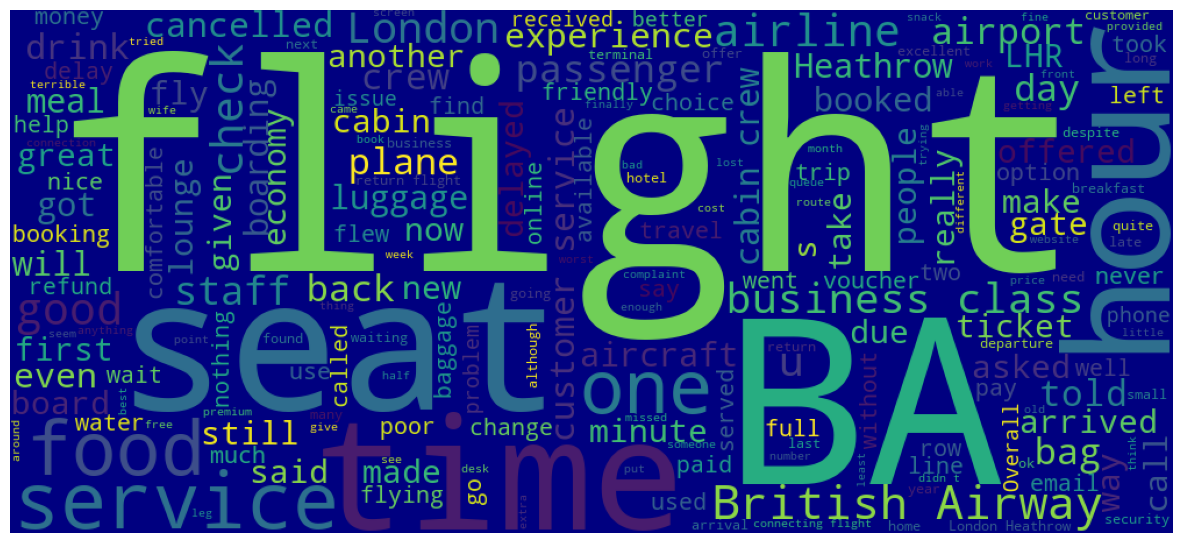

In [9]:
review_word = []
for i in df['reviews']:
    a = i.split(' ')
    for x in a:
        review_word.append(x)
unique_string = (" ").join(review_word)
wc = WordCloud(width=1000,height=450,background_color='navy').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

From the wordcloud above, we can easily see that the key of topics in customer review are flight, seat, service and time. It shows that people are actively talking about their experience on the plane and the staff

<h3>Satisfication of customers<h3>

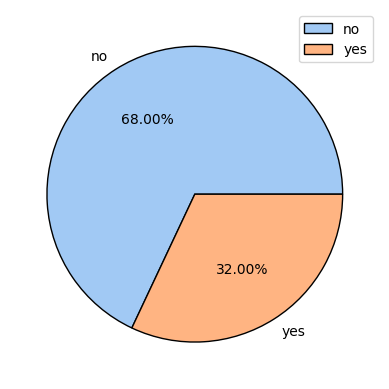

In [10]:
soc = df.groupby('Recommended')['reviews'].count().reset_index()
plt.pie(soc['reviews'],labels=soc['Recommended'],autopct='%.2f%%',colors=sns.color_palette('pastel'),wedgeprops={"edgecolor":"k"},)
plt.legend()
plt.show()

From the pie chart above, we know that 68% of passengers are dissatisfied with British Airways services. Let's break down the data to find what make passengers dissatisfied:

<h3>View rating of BA service by passenger that dissatisfied with British Airways<h3>

In [11]:
df_soc = df[df['Recommended']=='no']
df_soc.describe()

,Unnamed: 0,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity
count,680.000000,592.000000,584.000000,481.000000,335.000000,623.000000,680.000000,211.000000
mean,476.091176,2.087838,2.416096,1.854470,2.197015,1.784912,1.525000,1.516588
std,286.581385,1.098709,1.310918,1.066354,1.241736,1.164299,0.833375,0.967796
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,230.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,468.500000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,717.250000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
max,997.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


<h3>Analysis food on airways<h3>

In [12]:
data = df_soc[df_soc['reviews'].str.contains('food | drink')]
data['reviews'].to_csv('test.csv')

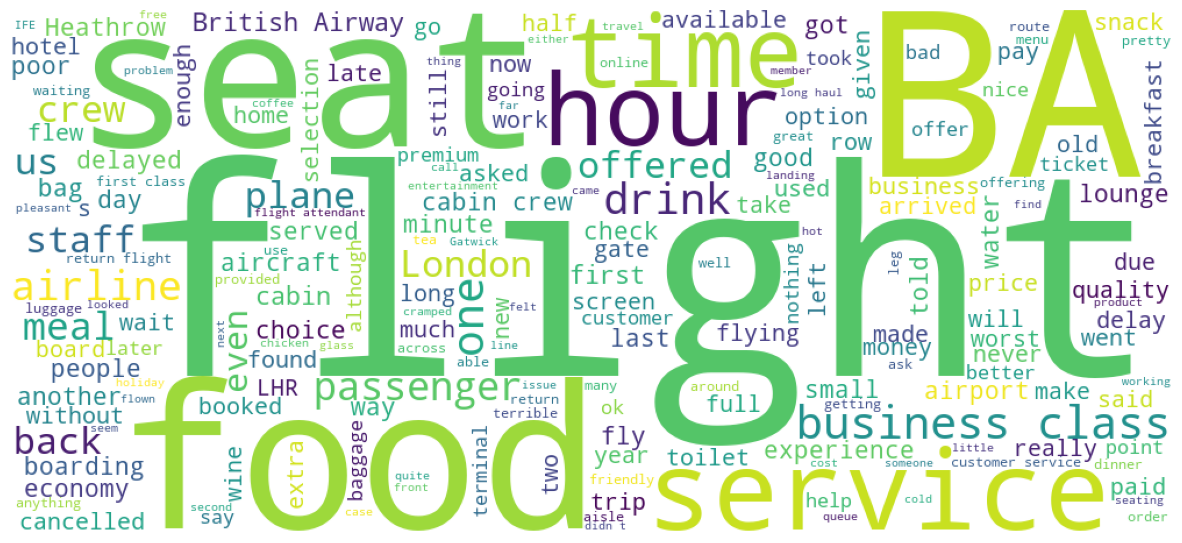

In [13]:
review_word = []
for i in data['reviews']:
    a = i.split(' ')
    for x in a:
        review_word.append(x)
unique_string = (" ").join(review_word)
wc = WordCloud(width=1000,height=450,background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

I analyze the test.csv file and get infomation that:
  
    1. Time to deliver the order is too long
    2. For free catering just bottle of water and a packet of crisps
    3. Minimal selection of food items for purchase


<h3>Analysis value for money<h3>

In [14]:
data = df_soc[df_soc['reviews'].str.contains('money | refund & value')]
data['reviews'].to_csv('test2.csv')

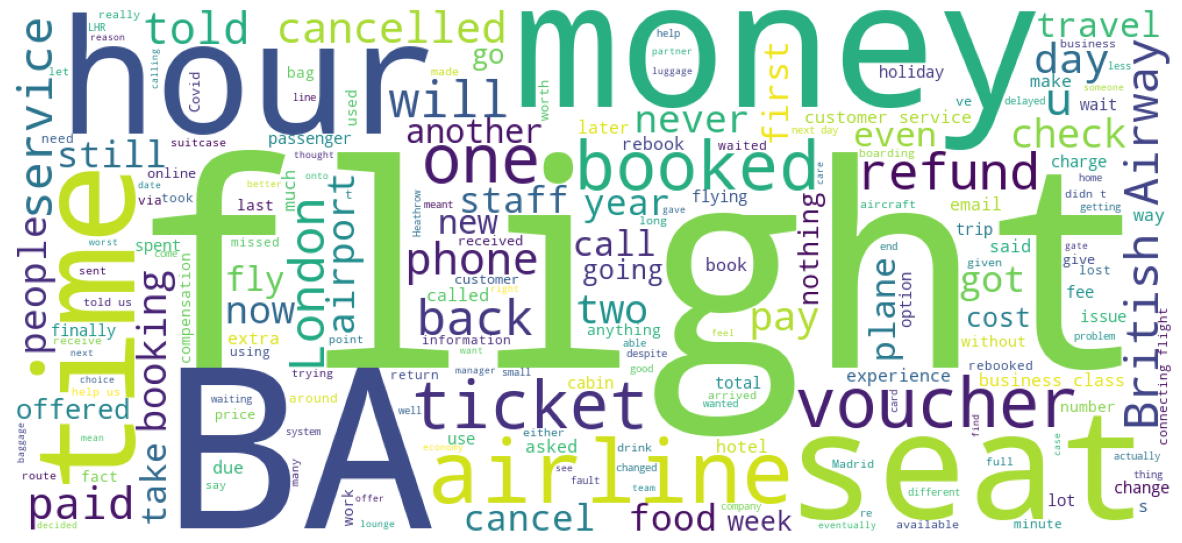

In [15]:
review_word = []
for i in data['reviews']:
    a = i.split(' ')
    for x in a:
        review_word.append(x)
unique_string = (" ").join(review_word)
wc = WordCloud(width=1000,height=450,background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

What I get from analysis the data is that:

    1. The refund takes a lot of time
    2. Forced to use of vouchers however it was useless
    3. Long delay time